In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob

In [3]:
# VARIABLES
DATA_DIR = "/home/jetbot/Data"

In [4]:
from imageio import imread

def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(imread(f))
            labels.append(int(d))
    return images, labels

In [5]:
train_data_directory = os.path.join(DATA_DIR, "TrafficSigns/Training")
test_data_directory = os.path.join(DATA_DIR, "TrafficSigns/Testing")

In [6]:
images, labels = load_data(train_data_directory)

In [7]:
import matplotlib.pyplot as plt

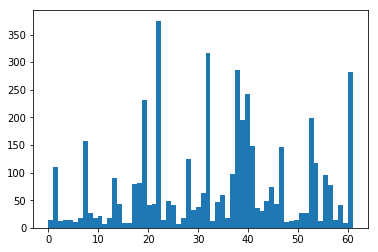

In [8]:
plt.hist(labels, 62)
plt.show()

In [9]:
# Determine the (random) indexes of the images
traffic_signs = [300, 2250, 3650, 4000]

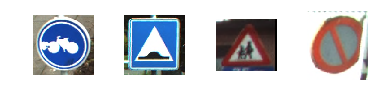

In [10]:
for i in range(len(traffic_signs)):
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.imshow(images[traffic_signs[i]])
    plt.subplots_adjust(wspace=0.5)

plt.show()

In [11]:
def show_images(images, cmap=None):
    # Fill out the subplots with the random images and add shape, min and max values
    for i in range(len(traffic_signs)):
        plt.subplot(1, 4, i+1)
        plt.axis('off')
        plt.imshow(images[traffic_signs[i]], cmap=cmap)     
        plt.subplots_adjust(wspace=0.5)
        plt.show()
        print("shape: {0}, min: {1}, max: {2}".format(images[traffic_signs[i]].shape, 
                                                      images[traffic_signs[i]].min(), 
                                                      images[traffic_signs[i]].max()))

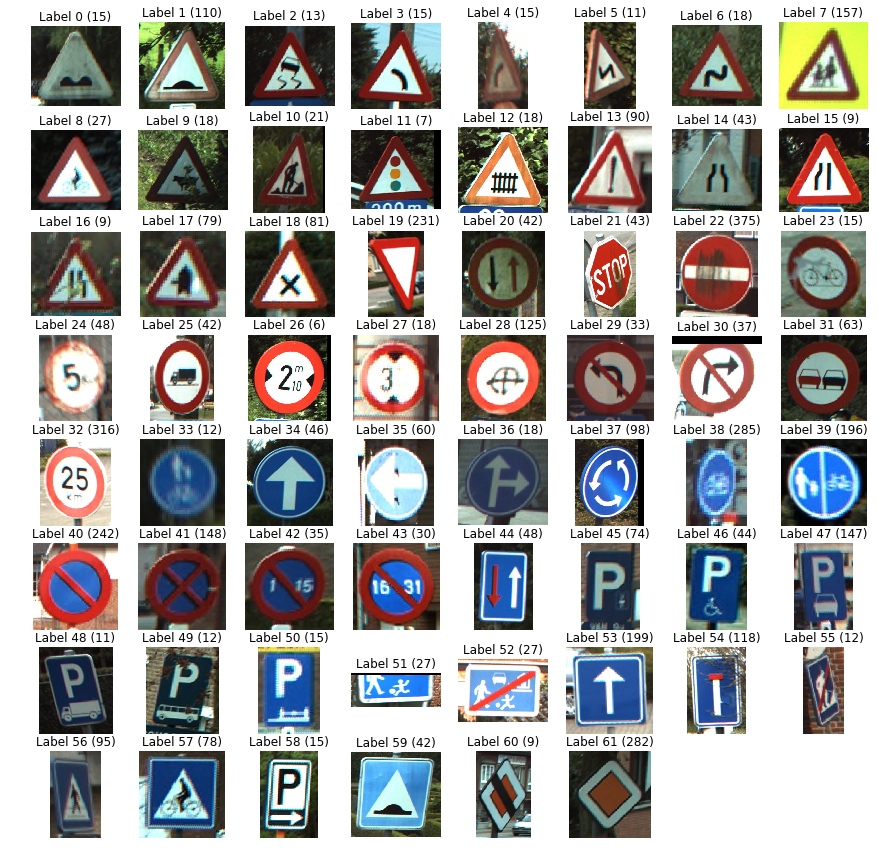

In [12]:
# Get the unique labels 
unique_labels = set(labels)

# Initialize the figure
plt.figure(figsize=(15, 15))

# Set a counter
i = 1

# For each unique label,
for label in unique_labels:
    # You pick the first image for each label
    image = images[labels.index(label)]
    # Define 64 subplots 
    plt.subplot(8, 8, i)
    # Don't include axes
    plt.axis('off')
    # Add a title to each subplot 
    plt.title("Label {0} ({1})".format(label, labels.count(label)))
    # Add 1 to the counter
    i += 1
    # And you plot this first image 
    plt.imshow(image)
    
# Show the plot
plt.show()

In [16]:
from skimage import transform
import numpy as np

In [17]:
# Rescale the images in the `images` array
images28 = [transform.resize(image, (28, 28)) for image in images]

In [18]:
# Import `rgb2gray` from `skimage.color`
from skimage.color import rgb2gray

# Convert `images28` to an array
images28 = np.array(images28)

# Convert `images28` to grayscale
images28 = rgb2gray(images28)

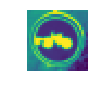

shape: (28, 28), min: 0.1353431232493, max: 0.9921568627450982


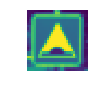

shape: (28, 28), min: 0.05954135504201682, max: 0.9921568627450982


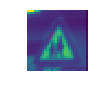

shape: (28, 28), min: 0.020632878151260838, max: 0.984797130602241


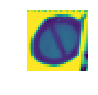

shape: (28, 28), min: 0.30990793417366996, max: 0.9921568627450982


In [19]:
show_images(images28)

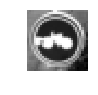

shape: (28, 28), min: 0.1353431232493, max: 0.9921568627450982


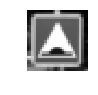

shape: (28, 28), min: 0.05954135504201682, max: 0.9921568627450982


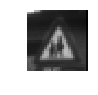

shape: (28, 28), min: 0.020632878151260838, max: 0.984797130602241


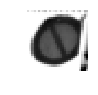

shape: (28, 28), min: 0.30990793417366996, max: 0.9921568627450982


In [20]:
show_images(images28, cmap="gray")

In [21]:
import tensorflow as tf

In [32]:
# Initialize placeholders 
x = tf.placeholder(dtype = tf.float32, shape = [None, 28, 28])
y = tf.placeholder(dtype = tf.int32, shape = [None])

# Flatten the input data
images_flat = tf.contrib.layers.flatten(x)

# Fully connected layer 
logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.relu)

# Define a loss function
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, 
                                                                    logits = logits))
# Define an optimizer 
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

# Convert logits to label indexes
correct_pred = tf.argmax(logits, 1)

# Define an accuracy metric
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [25]:
print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", correct_pred)

images_flat:  Tensor("Flatten/flatten/Reshape:0", shape=(?, 784), dtype=float32)
logits:  Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(?,), dtype=int64)


In [33]:
tf.set_random_seed(1234)
sess = tf.Session()

sess.run(tf.global_variables_initializer())

for i in range(201):
        print('EPOCH', i)
        _, accuracy_val = sess.run([train_op, accuracy], feed_dict={x: images28, y: labels})
        if i % 10 == 0:
            print("Loss: ", loss)
        print('DONE WITH EPOCH')

EPOCH 0


ValueError: Cannot feed value of shape (4575, 28, 28, 3) for Tensor 'Placeholder_2:0', which has shape '(?, 28, 28)'

[53, 20, 41, 39, 35, 53, 59, 61, 32, 14]
[53 20 41 38 22 53  1 61 32  7]


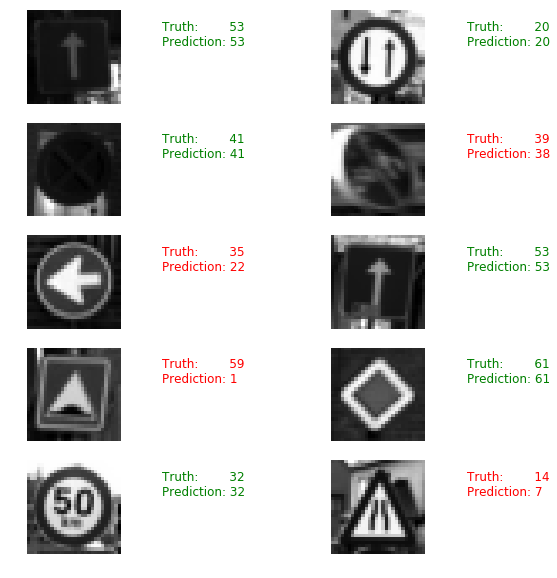

In [27]:
import random

# Pick 10 random images
sample_indexes = random.sample(range(len(images28)), 10)
sample_images = [images28[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "correct_pred" operation
predicted = sess.run([correct_pred], feed_dict={x: sample_images})[0]
                        
# Print the real and predicted labels
print(sample_labels)
print(predicted)

# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i],  cmap="gray")

plt.show()

In [29]:
# Import `skimage`
from skimage import transform

# Load the test data
test_images, test_labels = load_data(test_data_directory)

# Transform the images to 28 by 28 pixels
test_images28 = [transform.resize(image, (28, 28)) for image in test_images]

# Convert to grayscale
from skimage.color import rgb2gray
test_images28 = rgb2gray(np.array(test_images28))

# Run predictions against the full test set.
predicted = sess.run([correct_pred], feed_dict={x: test_images28})[0]

# Calculate correct matches 
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])

# Calculate the accuracy
accuracy = match_count / len(test_labels)

# Print the accuracy
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.690


In [34]:
# Close session
sess.close()

In [35]:
imagesc = [transform.resize(image, (28, 28)) for image in images]

In [45]:
# Convert `images28` to an array
imagesc = np.array(imagesc)

# Convert `images28` to grayscale
imagesc = rgb2gray(imagesc)

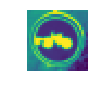

shape: (28, 28), min: 0.1353431232493, max: 0.9921568627450982


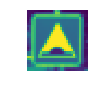

shape: (28, 28), min: 0.05954135504201682, max: 0.9921568627450982


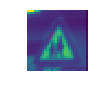

shape: (28, 28), min: 0.020632878151260838, max: 0.984797130602241


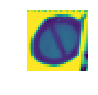

shape: (28, 28), min: 0.30990793417366996, max: 0.9921568627450982


In [46]:
show_images(imagesc)

In [47]:
# Initialize placeholders 
x = tf.placeholder(dtype = tf.float32, shape = [None, 28, 28])
y = tf.placeholder(dtype = tf.int32, shape = [None])

# Flatten the input data
images_flat = tf.contrib.layers.flatten(x)

# Fully connected layer 
logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.relu)

# Define a loss function
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, 
                                                                    logits = logits))
# Define an optimizer 
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

# Convert logits to label indexes
correct_pred = tf.argmax(logits, 1)

# Define an accuracy metric
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [48]:
print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", correct_pred)

images_flat:  Tensor("Flatten_4/flatten/Reshape:0", shape=(?, 784), dtype=float32)
logits:  Tensor("fully_connected_4/Relu:0", shape=(?, 62), dtype=float32)
loss:  Tensor("Mean_8:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax_4:0", shape=(?,), dtype=int64)


In [49]:
tf.set_random_seed(1234)
sess = tf.Session()

sess.run(tf.global_variables_initializer())

for i in range(201):
        print('EPOCH', i)
        _, accuracy_val = sess.run([train_op, accuracy], feed_dict={x: imagesc, y: labels})
        if i % 10 == 0:
            print("Loss: ", loss)
        print('DONE WITH EPOCH')

EPOCH 0
Loss:  Tensor("Mean_8:0", shape=(), dtype=float32)
DONE WITH EPOCH
EPOCH 1
DONE WITH EPOCH
EPOCH 2
DONE WITH EPOCH
EPOCH 3
DONE WITH EPOCH
EPOCH 4
DONE WITH EPOCH
EPOCH 5
DONE WITH EPOCH
EPOCH 6
DONE WITH EPOCH
EPOCH 7
DONE WITH EPOCH
EPOCH 8
DONE WITH EPOCH
EPOCH 9
DONE WITH EPOCH
EPOCH 10
Loss:  Tensor("Mean_8:0", shape=(), dtype=float32)
DONE WITH EPOCH
EPOCH 11
DONE WITH EPOCH
EPOCH 12
DONE WITH EPOCH
EPOCH 13
DONE WITH EPOCH
EPOCH 14
DONE WITH EPOCH
EPOCH 15
DONE WITH EPOCH
EPOCH 16
DONE WITH EPOCH
EPOCH 17
DONE WITH EPOCH
EPOCH 18
DONE WITH EPOCH
EPOCH 19
DONE WITH EPOCH
EPOCH 20
Loss:  Tensor("Mean_8:0", shape=(), dtype=float32)
DONE WITH EPOCH
EPOCH 21
DONE WITH EPOCH
EPOCH 22
DONE WITH EPOCH
EPOCH 23
DONE WITH EPOCH
EPOCH 24
DONE WITH EPOCH
EPOCH 25
DONE WITH EPOCH
EPOCH 26
DONE WITH EPOCH
EPOCH 27
DONE WITH EPOCH
EPOCH 28
DONE WITH EPOCH
EPOCH 29
DONE WITH EPOCH
EPOCH 30
Loss:  Tensor("Mean_8:0", shape=(), dtype=float32)
DONE WITH EPOCH
EPOCH 31
DONE WITH EPOCH
EPOCH 